## Contents <a id='home'></a>
## [1. Loading the Dataset](#ltd)
## [2. Data Preprocessing](#dp)
## [3. Fine Tuning Bert](#ftb)
## [4. Test set](#ts)

The following code is used to fine-tune a transformer encoder model on headline popularity dataset.
For further information, please look at subsection III-C ([link](https://ieeexplore.ieee.org/abstract/document/10154027))

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, SequentialSampler
import numpy as np
import time
import datetime
import random
from sklearn.metrics import mean_squared_error
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import seaborn as sns



In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

device = torch.device('cuda:0')
print(device)

No GPU available, using the CPU instead.
cuda:0


In [13]:
TRAIN_DATA_PATH = './ProcessedData/split/train.feather'
TEST_DATA_PATH = './ProcessedData/split/test.feather'
VALID_DATA_PATH = './ProcessedData/split/valid.feather'
MODEL_PATH = './HP_models'

BATCH_SIZE = 64
MODEL_NAME = 'bert-base-uncased'

EPOCHS = 20
SEED_VALUE = 42 # Set the seed value all over the place to make this reproducible.


# 2. loading the dataset <a id='ltd'></a>
[home](#home)

# 3. Data Preprocessing <a id='dp'></a>
[home](#home)

In [6]:

df_train = pd.read_feather(TRAIN_DATA_PATH)
df_test = pd.read_feather(TEST_DATA_PATH)
df_valid = pd.read_feather(VALID_DATA_PATH)

print(f'Length of the training data = {str(len(df_train))}')
print(f'Length of the test data = {str(len(df_test))}')
print(f'Length of the valid data = {str(len(df_valid))}')

## 3.1 Bert Tokenizer

In [8]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True)

In [ ]:
def get_raw_data(df_data):
    sentences = df_data.post_text1.values
    labels = df_data.q9_favorite_count_norm.values
    labels = [float(l) for l in labels]
    return sentences, labels

#tokenize data
def tokenizer_all(sentences):
    input_ids = []
    attention_masks = []
    for sent in sentences:
        encoded_input = tokenizer.encode_plus(
                                sent,
                                add_special_tokens= True,
                                max_length= 52,
                                pad_to_max_length=True,
                                return_attention_mask= True,
                                return_tensors = 'pt')

        input_ids.append(encoded_input['input_ids'])


        attention_masks.append(encoded_input['attention_mask'])
    return input_ids, attention_masks

def list2tensor(input_ids, attention_masks, labels):
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels


def prepare_data(df_data):
    sentences, labels = get_raw_data(df_data)
    input_ids, attention_masks = tokenizer_all(sentences)
    input_ids, attention_masks, labels = list2tensor(input_ids, attention_masks, labels)
    dataset=  TensorDataset(input_ids, attention_masks, labels)
    train_dataloader = DataLoader(
            dataset,  # The training samples.
            sampler = SequentialSampler(dataset),
            batch_size = BATCH_SIZE # Trains with this batch size.
    
        )
    return train_dataloader, dataset



In [ ]:
train_dataloader, train_dataset = prepare_data(df_data=df_train)
test_dataloader, test_dataset = prepare_data(df_data=df_test)
valid_dataloader, valid_dataset = prepare_data(df_data=df_valid)

# 4. Fine Tuning Bert <a id = 'ftb'></a>
[home](#home)

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME, # We use the 12-layer BERT model, with an uncased vocab.
    num_labels = 1, # The number of output labels--1 for regression.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    #cache_dir= '/local/data1/omidvar/codes/HG/transformercashe'
)

# move the model to GPU
model.cuda(device)

In [ ]:
# We are interested in printing the parameters of the model

params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                 eps = 1e-8)

In [28]:

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

In [10]:
def mean_squared(preds, labels):
    return mean_squared_error(labels, preds)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def eval_model(model, dataloader, verbose=True):
    t0 = time.time()
    model.eval()

    # Tracking variables 
    total_accuracy = 0
    total_loss = 0

    for batch in dataloader:
        # Unpack this training batch from our dataloader.
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels  
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        with torch.no_grad():        
            result = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)
            
        # Get the loss and "logits" output by the model.
        loss = result.loss
        logits = result.logits

        # Accumulate the validation loss.
        total_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch 
        total_accuracy += mean_squared(logits, label_ids)

    # Calculate final accuracy for the run
    avg_accuracy = total_accuracy / len(valid_dataloader)
    

    # Calculate the average loss over all of the batches.
    avg_loss = total_loss / len(valid_dataloader)

    
    validation_time = format_time(time.time() - t0)

    if verbose:
        print("  Accuracy: {0:.2f}".format(avg_accuracy))
        print("  Average Validation Loss: {}".format(avg_loss))

    return avg_accuracy, avg_loss, validation_time


def make_dir(path):
    shutil.rmtree(path)
    os.makedirs(path)

def save_model(model, path, epoch):
    path = os.path.join(path, str(epoch))
    if not os.path.exists(path):
        os.makedirs(path)
    model.save_pretrained(path)
   

In [ ]:


# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed_all(SEED_VALUE)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

make_dir(MODEL_PATH)

all_batch_loss = []

# For each epoch...
for epoch_i in range(0, EPOCHS):
    
    total_eval_loss1 = 0
    total_eval_accuracy1 = 0
    if epoch_i == 0:
        avg_val_accuracy, avg_val_loss = eval_model(model, valid_dataloader)


    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Training...')
    
    
    #Save the model
    if epoch_i != 0:
        save_model(model,MODEL_PATH, epoch_i)
    
    
    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        #Clearn previously calculated gradients
        model.zero_grad()        

        # Perform a forward pass 
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits
        
        all_batch_loss.append([epoch_i, step, loss.item()])
        
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.   loss:{}'.format(step, len(train_dataloader), elapsed,loss.item()))
        
        
        # Accumulate the training loss over all of the batches
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0 (preventing exploding gradients problem)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters 
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    avg_val_accuracy, avg_val_loss, validation_time = eval_model(model, valid_dataloader)
    
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [36]:
make_dir(os.path.join(MODEL_PATH, "Logs"))

with open(os.path.join(MODEL_PATH, "Logs", 'training_stats'), 'wb') as f:
    pickle.dump(training_stats, f)


In [37]:

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

df_stats.to_csv(os.path.join(MODEL_PATH, "Logs", 'training_stats.csv'))

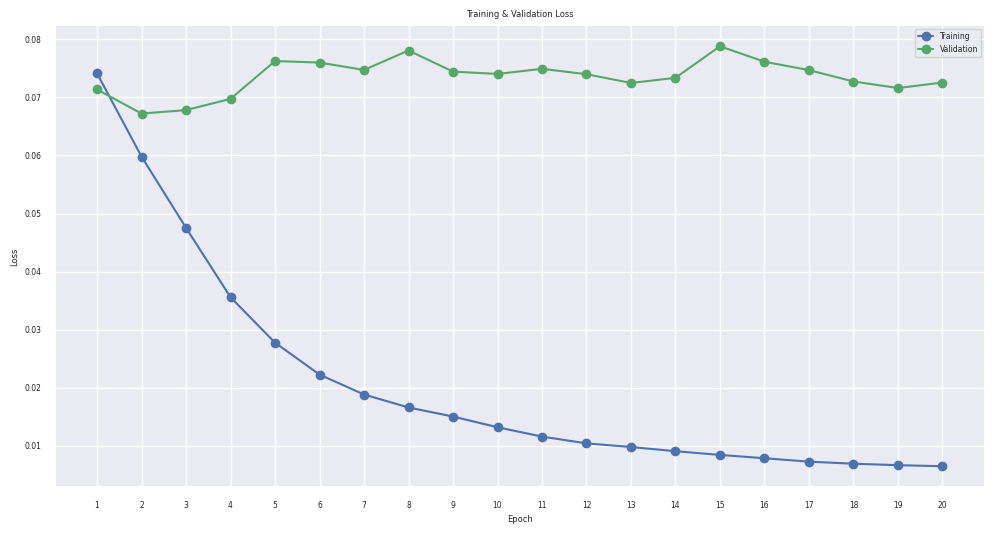

In [38]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=0.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

xticks_list = []
for i in range(len(training_stats)):
    xticks_list.append(i+1)

plt.xticks(xticks_list)

plt.savefig( os.path.join(MODEL_PATH, "Logs", 'trainloss.jpg'))

# 5. Test Set <a id='ts'></a>
[home](#home)

In [ ]:
epoch = 3

model_test = BertForSequenceClassification.from_pretrained('./saved/'+str(epoch))
tokenizer_test = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model_test = model_test.cuda()

In [ ]:
total_test_loss1 = 0
total_test_accuracy1 = 0

#see how model is working without training
# Evaluate data for one epoch
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    with torch.no_grad():        
        result = model_test(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

    loss = result.loss
    logits = result.logits

    # Accumulate the validation loss.
    total_test_loss1 += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences, and
    # accumulate it over all batches.
    #total_eval_accuracy += flat_accuracy(logits, label_ids)
    total_test_accuracy1 += mean_squared(logits, label_ids)

# Report the final accuracy for this validation run.
avg_test_accuracy = total_test_accuracy1 / len(test_dataloader)
print("  Accuracy: {0:.2f}".format(avg_test_accuracy))

# Calculate the average loss over all of the batches.
avg_test_loss = total_test_loss1 / len(test_dataloader)

print("  Average test Loss: {}".format(avg_test_loss))
